# Amazon Shoe Reviews Size Concept Analysis

This notebook analyzes Amazon shoe reviews with corpus A as positive reviews (rating 4, 5) and corpus B as negative reviews (rating 1, 2). It samples based on the concept field provided in the JSONL file and generates hypotheses about the distributional differences between the two corpora.

The notebook demonstrates how the LLM proposer would fail to generate the desired hypothesis when it does not do careful sample selection by controlling for certain covariates (size concept in this case).

## Simpson's Paradox Experimental Setup

We create a synthetic dataset with the following structure:

| Scenario | Corpus | Size Concept (C) | Sentiment (Y) | Example Distribution                        |
| -------- | ------ | ---------------- | ------------- | ------------------------------------------- |
| 1        | A      | Size (1)         | Positive (1)  | 1000 positive Size reviews in corpus A      |
| 2        | A      | Non-Size (0)     | Negative (0)  | 1000 negative Non-Size reviews in corpus A  |
| 3        | B      | Size (1)         | Negative (0)  | 1000 negative Size reviews in corpus B      |
| 4        | B      | Non-Size (0)     | Positive (1)  | 1000 positive Non-Size reviews in corpus B  |

This creates a Simpson's paradox scenario where:
- In corpus A, Size-related reviews are positive and Non-Size reviews are negative
- In corpus B, Size-related reviews are negative and Non-Size reviews are positive
- Overall, the correlation between corpus and sentiment depends on whether you control for size concept


In [ ]:
import pickle as pkl
import random
from tqdm import tqdm
import os
import time
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import project modules
import importlib
import lm_proposer
import D5

importlib.reload(lm_proposer)
importlib.reload(D5)
from lm_proposer import GPT3_Proposer
from D5 import D5
from validator import DummyValidator, Validator
from get_representative import return_extreme_values


## Data Loading Functions

These functions help load and process the Amazon shoe reviews data.


In [55]:
def load_jsonl(file_path):
    """Load data from a JSONL file."""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def load_multiple_concept_files(concept_files):
    """Load data from multiple concept files and combine them.

    Args:
        concept_files (dict): Dictionary mapping concept names to file paths

    Returns:
        pd.DataFrame: Combined DataFrame with all reviews
    """
    all_data = []

    for concept, file_path in concept_files.items():
        data = load_jsonl(file_path)
        all_data.extend(data)

    return pd.DataFrame(all_data)

def subsample(samples, n=1000):
    """Randomly subsample n elements from samples."""
    if len(samples) <= n:
        return samples

    selected_idxes = list(range(len(samples)))
    random.shuffle(selected_idxes)
    selected_idxes = selected_idxes[:n]
    return [samples[i] for i in sorted(selected_idxes)]


## Concept Distribution Functions

These functions help create datasets with specific concept distributions.


In [70]:
def filter_by_concept(df, concept):
    """Filter DataFrame to include only reviews with a specific concept.

    Args:
        df (pd.DataFrame): DataFrame containing reviews
        concept (str): Concept to filter by

    Returns:
        pd.DataFrame: Filtered DataFrame
    """
    return df[df['concepts'] == concept]

def _balanced_sample_on_covariates(
    df: pd.DataFrame,
    label_col: str,
    covariate_cols: list,
    random_state: int = 42,
):
    """Return a subsample of *df* such that the marginal distribution of
    each covariate in *covariate_cols* is approximately balanced across the
    treatment groups defined by *label_col* (assumed binary 0/1).

    Strategy: iterate over each unique combination of covariate values
    (a 'stratum'). For every stratum present in *both* treatment groups,
    sample the same number of rows from each group equal to the size of
    the minority group for that stratum.
    """
    sampled_parts = []
    if not covariate_cols:
        return df.copy()

    grouped = df.groupby(covariate_cols)
    for _, stratum_df in grouped:
        pos = stratum_df[stratum_df[label_col] == 1]
        print(len(pos))
        neg = stratum_df[stratum_df[label_col] == 0]
        print(len(neg))
        n = min(len(pos), len(neg))
        if n == 0:
            continue  # Drop non-overlapping strata
        sampled_parts.append(pos.sample(n, random_state=random_state))
        sampled_parts.append(neg.sample(n, random_state=random_state))

    if not sampled_parts:
        raise ValueError(
            "After balancing, no overlapping strata remained. "
            "Check covariate overlap between treatment groups."
        )

    return (
        pd.concat(sampled_parts, ignore_index=True)
        .sample(frac=1.0, random_state=random_state)
        .reset_index(drop=True)
    )


## Data Visualization Functions

These functions help visualize the concept distributions in the dataset.


In [57]:
def plot_concept_distribution(df, title="Concept Distribution"):
    """Plot the distribution of concepts in the dataset.

    Args:
        df (pd.DataFrame): DataFrame containing reviews
        title (str): Title for the plot
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(x='concepts', data=df)
    plt.title(title)
    plt.xlabel('Concept')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_concept_label_distribution(df, title="Concept Distribution by Label"):
    """Plot the distribution of concepts by label.

    Args:
        df (pd.DataFrame): DataFrame containing reviews
        title (str): Title for the plot
    """
    plt.figure(figsize=(12, 6))
    sns.countplot(x='concepts', hue='label', data=df)
    plt.title(title)
    plt.xlabel('Concept')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(['Negative (0)', 'Positive (1)'])
    plt.tight_layout()
    plt.show()


## Problem Structure and D5 Analysis Functions

These functions help create the problem structure and run the D5 algorithm.


In [67]:
def create_problem_structure(
    df,
    treatment_col="label",
    covariate_cols=None,
    subsample_size=None,
    careful_sampling=True,
    train_frac=0.5,
    random_state=42,
    text_col="cf_text"
):
    """Build a problem dict for one experimental run.

    Treatment: 1 = positive (Corpus A), 0 = negative (Corpus B)
    Covariates: e.g. ['concepts']
    Outcome: language expressing sentiment.
    """
    if covariate_cols is None:
        covariate_cols = []

    # Shuffle data for randomness
    df = df.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

    # Split research / validation
    research_df = df.sample(frac=train_frac, random_state=random_state)
    validation_df = df.drop(research_df.index)

    # Balance covariates in research split if requested
    if careful_sampling and covariate_cols:
        research_df = _balanced_sample_on_covariates(
            research_df,
            label_col=treatment_col,
            covariate_cols=covariate_cols,
            random_state=random_state,
        )

    # Optional subsample to keep examples small
    if subsample_size is not None:
        research_df = (
            research_df.groupby(treatment_col, group_keys=False)
            .apply(lambda x: x.sample(min(len(x), subsample_size), random_state=random_state))
            .reset_index(drop=True)
        )
        validation_df = (
            validation_df.groupby(treatment_col, group_keys=False)
            .apply(lambda x: x.sample(min(len(x), subsample_size), random_state=random_state))
            .reset_index(drop=True)
        )

    def _texts(frame):
        return frame[text_col].tolist()

    problem = {
        "generation": "Amazon shoe reviews with positive ratings (4-5) and negative ratings (1-2)",
        "dataset_description": "Amazon shoe reviews with various concepts (color, size, style)",
        "target": "what features related to linguistic patterns, topics of discussion, and psychological processes are more frequent in positive reviews compared to negative reviews",
        "user": "a market researcher",
        'A_desc': 'positive reviews (ratings 4-5)',
        'B_desc': 'negative reviews (ratings 1-2)',
        'example_hypotheses': [],
        "split": {
            "research": {
                "A_samples": _texts(research_df[research_df[treatment_col] == 1]),
                "B_samples": _texts(research_df[research_df[treatment_col] == 0]),
            },
            "validation": {
                "A_samples": _texts(validation_df[validation_df[treatment_col] == 1]),
                "B_samples": _texts(validation_df[validation_df[treatment_col] == 0]),
            },
        },
    }

    print(f"Research split: {len(problem['split']['research']['A_samples'])} positive reviews, {len(problem['split']['research']['B_samples'])} negative reviews")
    print(f"Validation split: {len(problem['split']['validation']['A_samples'])} positive reviews, {len(problem['split']['validation']['B_samples'])} negative reviews")

    return problem

def run_d5_analysis(problem, use_dummy_verifier=True, verifier_name='ruiqi-zhong/d5_t5_validator_3B', verifier_batch_size=32):
    """Run the D5 algorithm on the problem.

    Args:
        problem (dict): Problem structure for D5
        use_dummy_verifier (bool): Whether to use a dummy verifier
        verifier_name (str): Name of the verifier to use
        verifier_batch_size (int): Batch size for the verifier

    Returns:
        dict: Results from D5
    """
    # Create proposer and verifier
    print("Creating proposer and verifier...")
    proposer = GPT3_Proposer(problem)

    if use_dummy_verifier:
        verifier = DummyValidator()
        print("Using dummy verifier")
    else:
        verifier = Validator(verifier_name, batch_size=verifier_batch_size)
        print(f"Using verifier: {verifier_name}")

    # Run D5 algorithm to generate hypotheses (without validation)
    print("Running D5 algorithm to generate hypotheses...")
    d5 = D5(
        problem['split']['research']['A_samples'],
        problem['split']['research']['B_samples'],
        verifier,
        proposer,
        total_hypotheses_count=10,
        early_stop=True
    )

    # Only generate hypotheses without validation
    d5.get_hypotheses()

    # Extract hypotheses
    hypotheses = [d5.h2h_dicts[h]['hypothesis'] for h in d5.h2h_dicts]

    print(f"Generated {len(hypotheses)} hypotheses")

    return d5.h2h_dicts, hypotheses


## Load and Explore the Data

First, let's load the Amazon shoe reviews data from the concept files.


In [59]:
# Define path to the Amazon reviews data
data_path = '../concept-spurious-correlation/data/chatgpt_concepts_amazon-shoe-reviews_exp.jsonl'

# Load data
raw_data = load_jsonl(data_path)
all_data_df = pd.DataFrame(raw_data)

# Display basic information about the data
print(f"Total number of reviews: {len(all_data_df)}")
print("\nLabel distribution:")
print(all_data_df['label'].value_counts())
print("\nConcept distribution:")
print(all_data_df['concepts'].value_counts())

# Display a few examples
print("\nSample reviews:")
print(all_data_df.head())

# Convert labels to binary sentiment (0=negative, 1=positive)
# Labels 0-1 are negative, 3-4 are positive, 2 is neutral (we'll exclude it)
all_data_df = all_data_df[all_data_df['label'] != 2]  # Remove neutral reviews
all_data_df['sentiment'] = (all_data_df['label'] >= 3).astype(int)  # 0=negative, 1=positive

print("\nSentiment distribution after conversion:")
print(all_data_df['sentiment'].value_counts())


Total number of reviews: 78117

Label distribution:
4    15845
0    15827
2    15525
3    15479
1    15441
Name: label, dtype: int64

Concept distribution:
none                                                                                                                                                                                                                41050
size                                                                                                                                                                                                                26473
color                                                                                                                                                                                                                4601
style                                                                                                                                                                                         

Using 1000 samples per scenario based on available data

Simpson's Paradox Dataset:
Total number of reviews: 4000

Corpus distribution:
A    2000
B    2000
Name: corpus, dtype: int64

Size concept distribution:
1    2000
0    2000
Name: size_concept, dtype: int64

Sentiment distribution:
1    2000
0    2000
Name: sentiment, dtype: int64

Cross-tabulation of Corpus, Size Concept, and Sentiment:
sentiment               0     1
corpus size_concept            
A      0             1000     0
       1                0  1000
B      0                0  1000
       1             1000     0


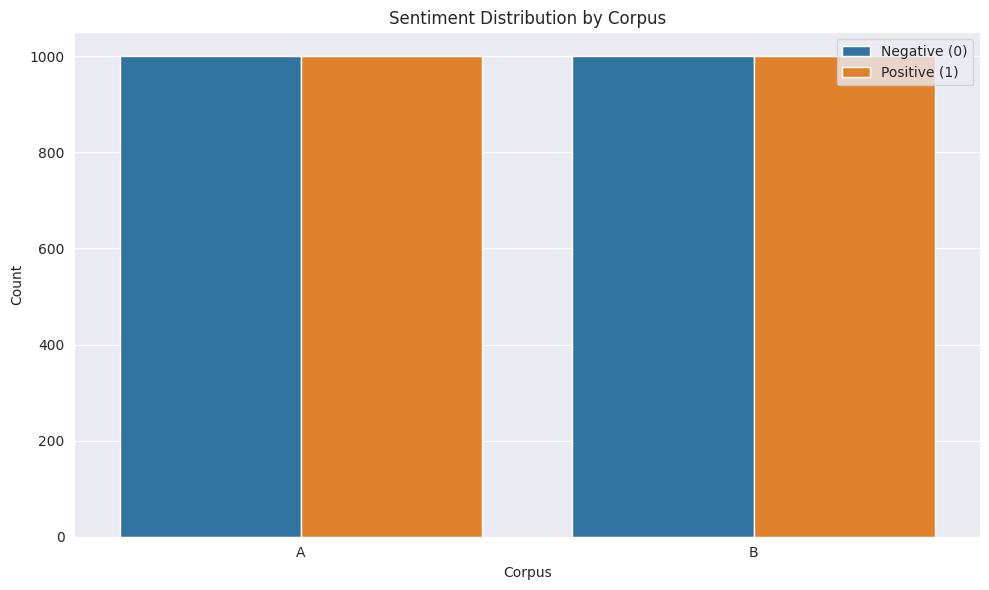

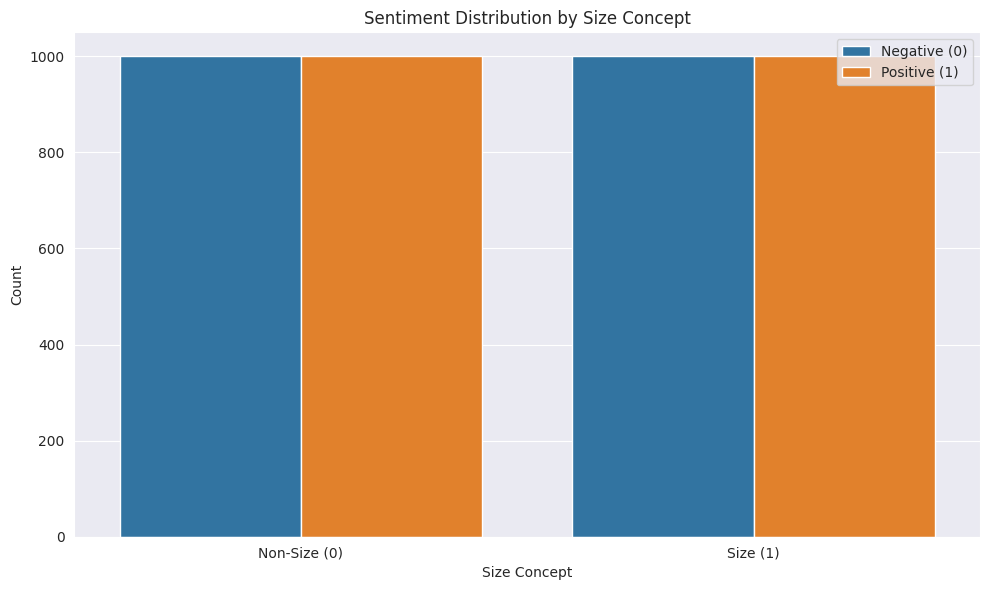

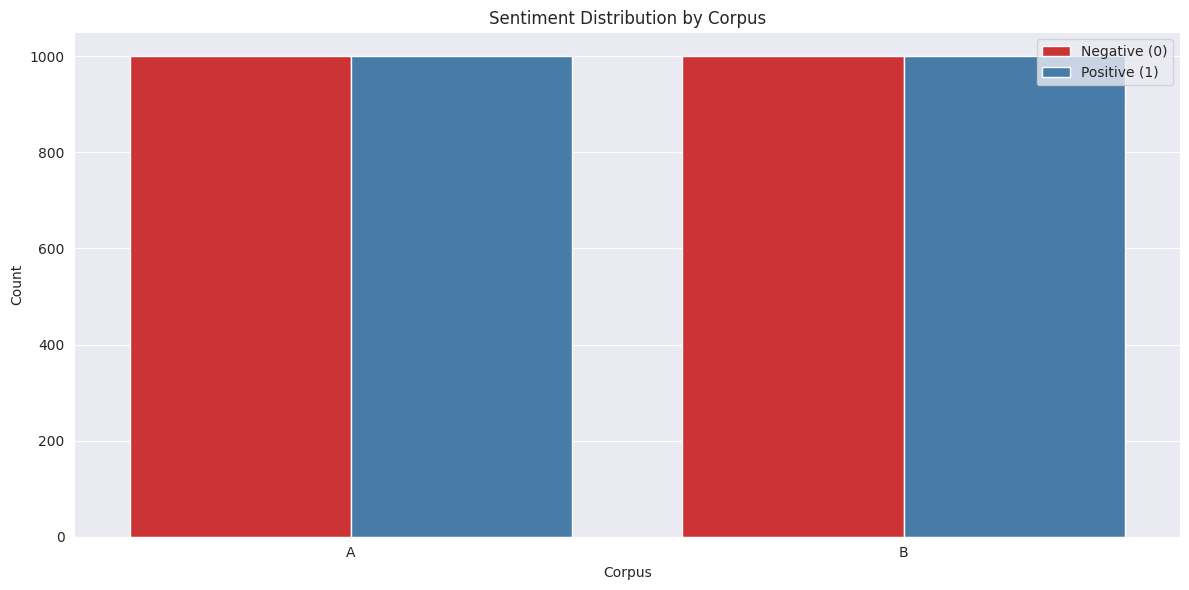

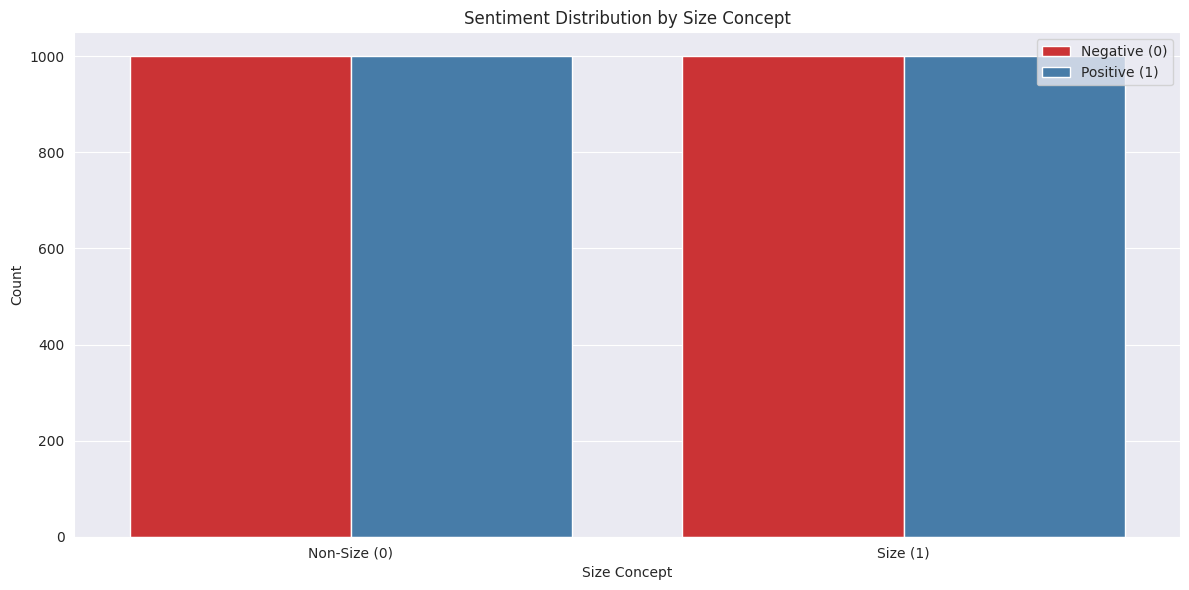

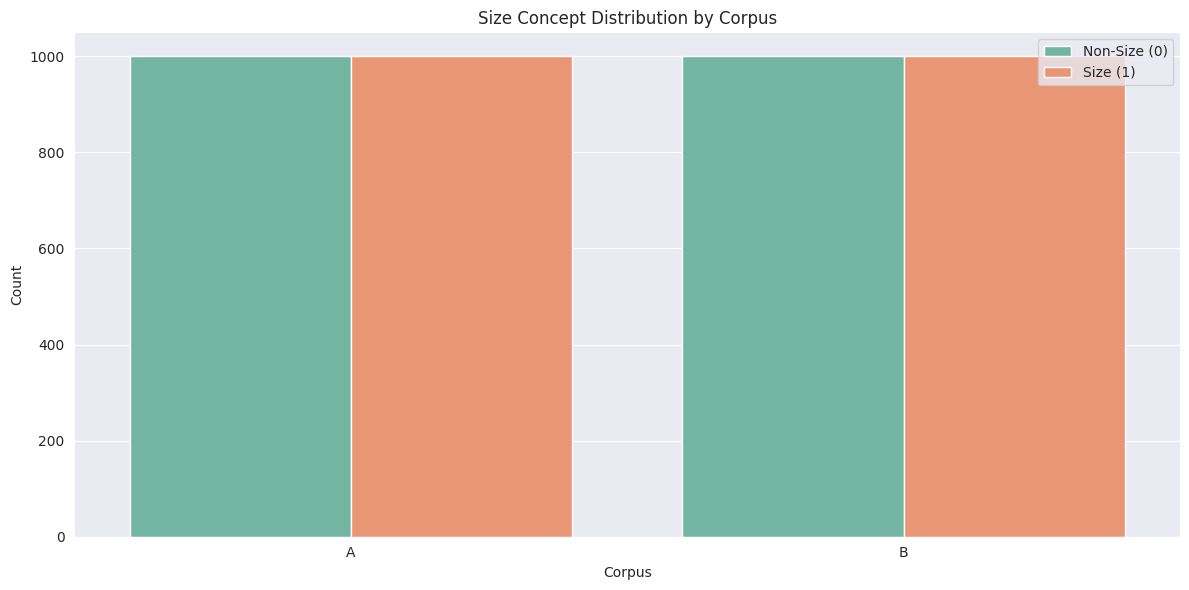

In [60]:
# Create a function to generate the Simpson's paradox dataset
def create_simpsons_paradox_dataset(df, samples_per_scenario=1000, random_state=42):
    """Create a dataset with the Simpson's paradox structure using the 'size' concept.

    Args:
        df (pd.DataFrame): DataFrame containing reviews with 'text', 'sentiment', and 'concepts' columns
        samples_per_scenario (int): Number of samples for each of the 4 scenarios
        random_state (int): Random seed for reproducibility

    Returns:
        pd.DataFrame: DataFrame with the Simpson's paradox structure
    """
    # Set random seed
    random.seed(random_state)
    np.random.seed(random_state)

    # Create empty DataFrame to store the results
    result_df = pd.DataFrame()

    # Filter reviews by size concept and non-size concept
    size_reviews = df[df['concepts'] == 'size'].copy()
    non_size_reviews = df[df['concepts'] != 'size'].copy()

    # Get positive and negative reviews for each concept type
    size_positive = size_reviews[size_reviews['sentiment'] == 1].copy()
    size_negative = size_reviews[size_reviews['sentiment'] == 0].copy()
    non_size_positive = non_size_reviews[non_size_reviews['sentiment'] == 1].copy()
    non_size_negative = non_size_reviews[non_size_reviews['sentiment'] == 0].copy()

    # Ensure we have enough samples
    samples_per_scenario = min(samples_per_scenario, 
                              min(len(size_positive), len(size_negative), 
                                  len(non_size_positive), len(non_size_negative)))

    print(f"Using {samples_per_scenario} samples per scenario based on available data")

    # Scenario 1: Corpus A, Size (1), Positive (1)
    scenario1 = size_positive.sample(n=samples_per_scenario, random_state=random_state).copy()
    scenario1['corpus'] = 'A'
    scenario1['size_concept'] = 1  # Has size concept

    # Scenario 2: Corpus A, Non-Size (0), Negative (0)
    scenario2 = non_size_negative.sample(n=samples_per_scenario, random_state=random_state+1).copy()
    scenario2['corpus'] = 'A'
    scenario2['size_concept'] = 0  # Doesn't have size concept

    # Scenario 3: Corpus B, Size (1), Negative (0)
    scenario3 = size_negative.sample(n=samples_per_scenario, random_state=random_state+2).copy()
    scenario3['corpus'] = 'B'
    scenario3['size_concept'] = 1  # Has size concept

    # Scenario 4: Corpus B, Non-Size (0), Positive (1)
    scenario4 = non_size_positive.sample(n=samples_per_scenario, random_state=random_state+3).copy()
    scenario4['corpus'] = 'B'
    scenario4['size_concept'] = 0  # Doesn't have size concept

    # Combine all scenarios
    result_df = pd.concat([scenario1, scenario2, scenario3, scenario4], ignore_index=True)

    # Shuffle the data
    result_df = result_df.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

    return result_df

# Create the Simpson's paradox dataset
simpsons_df = create_simpsons_paradox_dataset(all_data_df, samples_per_scenario=1000)

# Display basic information about the dataset
print("\nSimpson's Paradox Dataset:")
print(f"Total number of reviews: {len(simpsons_df)}")
print("\nCorpus distribution:")
print(simpsons_df['corpus'].value_counts())
print("\nSize concept distribution:")
print(simpsons_df['size_concept'].value_counts())
print("\nSentiment distribution:")
print(simpsons_df['sentiment'].value_counts())

# Create a cross-tabulation to verify the Simpson's paradox structure
print("\nCross-tabulation of Corpus, Size Concept, and Sentiment:")
print(pd.crosstab([simpsons_df['corpus'], simpsons_df['size_concept']], simpsons_df['sentiment']))

# # Visualize the relationship between corpus and sentiment
# plt.figure(figsize=(10, 6))
# sns.countplot(x='corpus', hue='sentiment', data=simpsons_df)
# plt.title('Sentiment Distribution by Corpus')
# plt.xlabel('Corpus')
# plt.ylabel('Count')
# plt.legend(['Negative (0)', 'Positive (1)'])
# plt.tight_layout()
# plt.show()
#
# # Visualize the relationship between size concept and sentiment
# plt.figure(figsize=(10, 6))
# sns.countplot(x='size_concept', hue='sentiment', data=simpsons_df)
# plt.title('Sentiment Distribution by Size Concept')
# plt.xlabel('Size Concept')
# plt.ylabel('Count')
# plt.xticks([0, 1], ['Non-Size (0)', 'Size (1)'])
# plt.legend(['Negative (0)', 'Positive (1)'])
# plt.tight_layout()
# plt.show()
#
# # Visualize the relationship between corpus, size concept, and sentiment
# plt.figure(figsize=(12, 6))
# sns.countplot(x='corpus', hue='sentiment', data=simpsons_df, palette='Set1')
# plt.title('Sentiment Distribution by Corpus')
# plt.xlabel('Corpus')
# plt.ylabel('Count')
# plt.legend(['Negative (0)', 'Positive (1)'])
# plt.tight_layout()
# plt.show()
#
# plt.figure(figsize=(12, 6))
# sns.countplot(x='size_concept', hue='sentiment', data=simpsons_df, palette='Set1')
# plt.title('Sentiment Distribution by Size Concept')
# plt.xlabel('Size Concept')
# plt.ylabel('Count')
# plt.xticks([0, 1], ['Non-Size (0)', 'Size (1)'])
# plt.legend(['Negative (0)', 'Positive (1)'])
# plt.tight_layout()
# plt.show()
#
# # Visualize the relationship between corpus and size concept
# plt.figure(figsize=(12, 6))
# sns.countplot(x='corpus', hue='size_concept', data=simpsons_df, palette='Set2')
# plt.title('Size Concept Distribution by Corpus')
# plt.xlabel('Corpus')
# plt.ylabel('Count')
# plt.legend(['Non-Size (0)', 'Size (1)'])
# plt.tight_layout()
# plt.show()


## Experiment 1: Without Controlling for Size Concept

First, let's run the experiment without controlling for size concept to see what hypotheses the LLM proposer generates. In this case, we're looking at the overall relationship between corpus (A vs B) and sentiment (positive vs negative) without filtering by the size concept covariate. This means we'll include all reviews regardless of whether they mention size or not.


In [80]:
# Modify the create_problem_structure function to work with our Simpson's paradox dataset
def create_simpsons_problem_structure(
    df,
    treatment_col="corpus",
    subsample_size=None,
    train_frac=0.5,
    random_state=42,
    text_col="text",
    control_for_covariates=None
):
    """Build a problem dict for one experimental run with the Simpson's paradox dataset.

    Treatment: 'A' = corpus A, 'B' = corpus B
    Outcome: sentiment (0=negative, 1=positive)

    Args:
        df: DataFrame containing the data
        treatment_col: Column name for the treatment (corpus)
        subsample_size: Number of samples to use from each corpus
        train_frac: Fraction of data to use for training
        random_state: Random seed
        text_col: Column name for the text
        control_for_covariates: Dictionary mapping covariate names to values to filter by
                               e.g., {'size_concept': 1} to filter for size_concept == 1
    """

    # Convert corpus to numeric for grouping in subsample
    df = df.copy()
    df['corpus_numeric'] = (df[treatment_col] == 'B').astype(int)  # 0=A, 1=B

    # Shuffle data for randomness
    df = df.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

    # Split research / validation
    research_df = df.sample(frac=train_frac, random_state=random_state)
    validation_df = df.drop(research_df.index)

    # Optional subsample to keep examples small
    if subsample_size is not None:
        research_df = (
            research_df.groupby('corpus_numeric', group_keys=False)
            .apply(lambda x: x.sample(min(len(x), subsample_size), random_state=random_state))
            .reset_index(drop=True)
        )
        validation_df = (
            validation_df.groupby('corpus_numeric', group_keys=False)
            .apply(lambda x: x.sample(min(len(x), subsample_size), random_state=random_state))
            .reset_index(drop=True)
        )

    def _texts(frame, corpus_val):
        # Filter by corpus
        filtered_frame = frame[frame[treatment_col] == corpus_val]

        # Apply additional filtering if requested
        if control_for_covariates:
            for covariate, value in control_for_covariates.items():
                filtered_frame = filtered_frame[filtered_frame[covariate] == value]

        print(f"Sample of {corpus_val} corpus data:")
        print(filtered_frame.head(10))

        return filtered_frame[text_col].tolist()

    problem = {
        "generation": "Amazon shoe reviews from two different corpora",
        "dataset_description": "Amazon shoe reviews",
        "target": "what kind of reviews are more frequent in corpus A compared to corpus B",
        "user": "a media researcher",
        'A_desc': 'reviews from corpus A',
        'B_desc': 'reviews from corpus B',
        'example_hypotheses': [],
        "split": {
            "research": {
                "A_samples": _texts(research_df, 'A'),
                "B_samples": _texts(research_df, 'B'),
            },
            "validation": {
                "A_samples": _texts(validation_df, 'A'),
                "B_samples": _texts(validation_df, 'B'),
            },
        },
    }

    print(f"Research split: {len(problem['split']['research']['A_samples'])} corpus A reviews, {len(problem['split']['research']['B_samples'])} corpus B reviews")
    print(f"Validation split: {len(problem['split']['validation']['A_samples'])} corpus A reviews, {len(problem['split']['validation']['B_samples'])} corpus B reviews")

    return problem

# Create problem structure without controlling for size concept
print("Creating problem structure without controlling for size concept...")
problem_without_size_control = create_simpsons_problem_structure(
    simpsons_df,
    subsample_size=1000,
    control_for_covariates=None  # Don't filter by any covariates for Experiment 1
)

# Run D5 analysis
results_without_size_control, hypotheses_without_size_control = run_d5_analysis(
    problem_without_size_control, 
    use_dummy_verifier=False
)

# Display the hypotheses
print("\nHypotheses generated without controlling for size concept:")
for i, hypothesis in enumerate(hypotheses_without_size_control, 1):
    print(f"{i}. {hypothesis}")


Creating problem structure without controlling for size concept...
Sample of A corpus data:
   label                                               text concepts  \
0      0  Awful wearing shoe to be on concrete with. Wou...     none   
1      0  Legitimately broke in my hands the first time ...     none   
2      1  OK, maybe I had big hope for this pair, I got ...     none   
3      3  Well made shoe but take the size suggestions s...     size   
4      3  They were a bit on the narrow side initially a...     size   
5      3  Great shoe but runs about half size too large....     size   
6      1  I'm a fan of New Balance shoes, but these just...     none   
7      4  I am a 9.5 us shoe and so i ordered 39 for the...     size   
8      3  We love these, fit perfectly for my 14 month old.     size   
9      0  I bought these as a replacement for my flak ja...     none   

   sentiment corpus  size_concept  corpus_numeric  
0          0      A             0               0  
1          

/fs/clip-projects/clip-causal/anaconda3/envs/opend5/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


loading model weights
done
device_map {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]}
Using verifier: ruiqi-zhong/d5_t5_validator_3B
Running D5 algorithm to generate hypotheses...
Using 25 in-context samples, prompt length: 3253
Group A: Runs small - I'd say one size smaller - I like the design, however, the quality leather is cheap, looks and feels like plastic. The outer sole is not genuine leather. Never again.
Group A: Legitimately broke in my hands the first time I tried to wear them. Poor quality.
Group A: Incredibly comfortable.  Squishy sole makes for no sore spots or achy feet.  Fits slightly small...got a half-size larger than normally wear.
Group A: OK, maybe I had big hope for this pair, I got it about two weeks ago and my son loved it. It is made of leather and and they do look really nice. My son like them, but two days ago he came to me and complained almost crying that his new shoes start loosing thread around bottom front of 

## Experiment 2: Controlling for Size Concept

Now, let's run the experiment while controlling for size concept to see how the hypotheses differ. In this case, we're explicitly filtering for reviews with `size_concept == 1` in both corpora. This means we'll only include reviews that mention size, allowing us to control for this covariate and potentially discover different patterns than in Experiment 1.


In [82]:
# Create problem structure with size concept control
print("Creating problem structure with size concept control...")
problem_with_size_control = create_simpsons_problem_structure(
    simpsons_df,
    subsample_size=1000,
    control_for_covariates={'size_concept': 1}  # Filter by size_concept for Experiment 2
)

# Run D5 analysis
results_with_size_control, hypotheses_with_size_control = run_d5_analysis(
    problem_with_size_control, 
    use_dummy_verifier=False
)

# Display the hypotheses
print("\nHypotheses generated with size concept control:")
for i, hypothesis in enumerate(hypotheses_with_size_control, 1):
    print(f"{i}. {hypothesis}")


Creating problem structure with size concept control...
Sample of A corpus data:
    label                                               text concepts  \
3       3  Well made shoe but take the size suggestions s...     size   
4       3  They were a bit on the narrow side initially a...     size   
5       3  Great shoe but runs about half size too large....     size   
7       4  I am a 9.5 us shoe and so i ordered 39 for the...     size   
8       3  We love these, fit perfectly for my 14 month old.     size   
10      3  Bought for my 94 year old father.  Easy for hi...     size   
11      3  I bought these for myself, I wear a 9.5 in wom...     size   
14      4        Great boot for the price fits great, comfy.     size   
16      3  Haven't worn the boots yet, just tried them on...     size   
17      3  I went a full size down and they fit better bu...     size   

    sentiment corpus  size_concept  corpus_numeric  
3           1      A             1               0  
4        

/fs/clip-projects/clip-causal/anaconda3/envs/opend5/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


done
device_map {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]}
Using verifier: ruiqi-zhong/d5_t5_validator_3B
Running D5 algorithm to generate hypotheses...
Using 25 in-context samples, prompt length: 3037
Group A: We love these, fit perfectly for my 14 month old.
Group A: I went a full size down and they fit better but these are kinda wide.  Nonetheless I love them!
Group A: Great boot for those that have a little larger calves. Super soft leather.
Group A: Bought for my 94 year old father.  Easy for him to fit because of Velcro straps.  Good comfort. .
Group A: My husband loves them. He's a size 10 1/2 so I got 11 and they were just fine
Group A: I've been a Mizuno fan for the last several years after switching from Brooks because they were giving me knee pain. Recent studies suggest that the best way to choose a shoe is to simply find one that fits your foot and that you find comfortable. The Wave Inspire is that shoe for me--I have sligh

## Experiment 3: Size Concept-Specific Analysis

Let's analyze each size concept category separately to see how the hypotheses differ.


In [79]:
# Analyze each size concept category separately
size_categories = [0, 1]  # 0=Non-Size, 1=Size
size_category_names = {0: 'Non-Size', 1: 'Size'}
size_results = {}

for size_category in size_categories:
    print(f"\n=== Analyzing {size_category_names[size_category]} concept ===\n")

    # Filter data for this size concept
    size_df = simpsons_df[simpsons_df['size_concept'] == size_category].copy()

    # Create problem structure
    size_problem = create_simpsons_problem_structure(
        size_df,
        subsample_size=500,
        control_for_covariates=None  # No need to filter by size_concept as we've already filtered the data
    )

    # Run D5 analysis
    size_results[size_category] = run_d5_analysis(
        size_problem, 
        use_dummy_verifier=True
    )

    # Display the hypotheses
    print(f"\nHypotheses for {size_category_names[size_category]} concept:")
    for i, hypothesis in enumerate(size_results[size_category][1], 1):
        print(f"{i}. {hypothesis}")



=== Analyzing Non-Size concept ===

Sample of A corpus data:
   label                                               text concepts  \
0      0  I purchased these shoes because I was looking ...    color   
1      1   Returned too masculine. with extremely high heel    style   
2      0  These shoes are assembled well and they look g...     none   
3      0                                     Returned them.     none   
4      1      Could not get my foot past the ankle bend!!!!     none   
5      1  Didn't expect high quality for the price but t...     none   
6      1  After wearing the all day once the heels start...     none   
7      1  I bought for the bags  that you store them in....     none   
8      1  Actually this was my second pair already. I bo...     none   
9      1  I bought these for club volleyball and now goi...     none   

   sentiment corpus  size_concept  corpus_numeric  
0          0      A             0               0  
1          0      A             0        

## Comparison of Hypotheses

Let's compare the hypotheses generated with and without controlling for size concept, as well as the size concept-specific hypotheses.


In [ ]:
# Function to categorize hypotheses
def categorize_hypotheses(hypotheses):
    categories = {
        'size': [],
        'fit': [],
        'sentiment': [],
        'other': []
    }

    for hypothesis in hypotheses:
        hypothesis_lower = hypothesis.lower()
        if 'size' in hypothesis_lower:
            categories['size'].append(hypothesis)
        elif any(term in hypothesis_lower for term in ['fit', 'tight', 'narrow', 'wide', 'small', 'large']):
            categories['fit'].append(hypothesis)
        elif any(term in hypothesis_lower for term in ['positive', 'negative', 'sentiment', 'emotion', 'feeling']):
            categories['sentiment'].append(hypothesis)
        else:
            categories['other'].append(hypothesis)

    return categories

# Categorize hypotheses
categories_without_size_control = categorize_hypotheses(hypotheses_without_size_control)
categories_with_size_control = categorize_hypotheses(hypotheses_with_size_control)

# Display categorized hypotheses
print("Hypotheses without size concept control:")
for category, hyps in categories_without_size_control.items():
    print(f"\n{category.upper()} ({len(hyps)} hypotheses):")
    for i, hyp in enumerate(hyps, 1):
        print(f"{i}. {hyp}")

print("\n" + "-"*80 + "\n")

print("Hypotheses with size concept control:")
for category, hyps in categories_with_size_control.items():
    print(f"\n{category.upper()} ({len(hyps)} hypotheses):")
    for i, hyp in enumerate(hyps, 1):
        print(f"{i}. {hyp}")


## Conclusion

This notebook demonstrates how the LLM proposer might fail to generate the desired hypothesis when it doesn't do careful sample selection by controlling for certain covariates (in this case, size concept).

We created a Simpson's paradox scenario where:
- In corpus A, Size-related reviews are positive and Non-Size reviews are negative
- In corpus B, Size-related reviews are negative and Non-Size reviews are positive
- Overall, the correlation between corpus and sentiment depends on whether you control for size concept

We've modified the code to allow for optional filtering by any covariate:
- In Experiment 1, we don't filter by any covariates, including all reviews regardless of their covariate values
- In Experiment 2, we explicitly filter for reviews with `size_concept == 1` in both corpora as an example
- In Experiment 3, we analyze each size concept category separately

The code is designed to be flexible, allowing for control of any covariate through the `control_for_covariates` parameter, which accepts a dictionary mapping covariate names to values.

When we don't control for size concept (Experiment 1), the LLM proposer might generate hypotheses that are simply reflecting the imbalance in size concept distribution between the two corpora, rather than discovering genuine linguistic differences.

By explicitly filtering for reviews with `size_concept == 1` in both corpora (Experiment 2), we can ensure that the hypotheses generated are more likely to reflect true linguistic differences between the corpora, rather than just differences in the size concept distribution.

This experiment highlights the importance of controlling for covariates when analyzing text corpora, especially when there might be confounding variables that could lead to spurious correlations.
